Fine-tuning BERT to solve the GLUE task - MRPC (Microsoft Research Paraphrase Corpus) for determining whether a pair of sentences are semantically equivalent.

Trained using Google Colab

Install dependencies

In [ ]:
!pip install transformers

In [ ]:
!pip install datasets

In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.12.3


Imports

In [ ]:
import torch
from datasets import load_dataset
import os
import pandas as pd
import random
import numpy as np
import time
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import sklearn.metrics as smetrics

from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler

In [ ]:
seed = 2020

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

Connecting to the GPU

In [ ]:
# Check GPU availablity and connect if found.
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Connecting to GPU - ', torch.cuda.get_device_name(0))
else:
    print('No GPU found. Using the CPU instead.')
    device = torch.device("cpu")

Connecting to GPU -  Tesla T4


Loading the dataset

In [ ]:
print('Loading dataset...')

train_dataset = load_dataset('glue', 'mrpc', split='train')
val_dataset = load_dataset('glue', 'mrpc', split='validation')
test_dataset = load_dataset('glue', 'mrpc', split='test')

Loading dataset...


In [ ]:
print(train_dataset)

Dataset({
    features: ['sentence1', 'sentence2', 'label', 'idx'],
    num_rows: 3668
})


Preprocess Text

In [ ]:
def preprocess_text(dataset, tokenizer, batch_size, seq_length = 64):
  '''
  Formats data to be in required format and creates a DataLoader for the formatted data

  Args:
  dataset: data to be processed
  tokenizer: tokenizer of the selected BERT model
  batch_size: number of examples in individual data batches
  seq_length: integer defining the sequence legnth of BERT inputs
  (default = 64, due to quadratic computation cost of attention)

  Returns:
  data_loader: DataLoader iterable containing randomly sampled batches of data having size `batch_size` in required format
  '''

  def encode(samples):
    return tokenizer(samples['sentence1'],
                     samples['sentence2'],
                     add_special_tokens=True,
                     max_length = seq_length,
                     truncation=True,
                     pad_to_max_length = True,
                     return_attention_mask = True)

  # Encode samples in dataset using map function
  dataset = dataset.map(encode, batched=True)

  # Change label to labels (required format for BERT model)
  dataset = dataset.map(lambda samples: {'labels': samples['label']}, batched=True)

  # Keep only required columns and change them to pytorch tensors
  dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

  # Create dataloader
  data_loader = DataLoader(dataset,
                            sampler = RandomSampler(dataset),
                            batch_size = batch_size
                            )

  return data_loader

In [ ]:
def init_model(bert_model_name, num_labels):
  '''
  Initialize pre-trained BERT model

  Args:
  bert_model_name: String. Name of the BERT model to be used.
  num_labels: Number of classification labels

  Returns:
  model: Pre-trained BERT model with a linear layer on top for classification, loaded to device
  '''

  # We are using BertForSequentialClassification for this task.
  # It is a pre-trained BERT model with a single linear layer on top for classification.
  model = BertForSequenceClassification.from_pretrained(bert_model_name,
                                                        num_labels = num_labels,
                                                        output_attentions = False,
                                                        output_hidden_states = False,
                                                        )
  # Set model to run on GPU
  model.cuda()

  # Print model parameters
  model_params = list(model.named_parameters())
  print("The model parameters are : ")
  print("Embedding Layer: ")
  for p in model_params[0:5]:
    print("{:<60} {:>10}".format(p[0], str(tuple(p[1].size()))))

  print("Transformer Layers: ")
  for p in model_params[5:25]:
    print("{:<60} {:>10}".format(p[0], str(tuple(p[1].size()))))

  print("Output Layer: ")
  for p in model_params[-4:]:
    print("{:<60} {:>10}".format(p[0], str(tuple(p[1].size()))))

  return model


In [ ]:
def init_optimizer(model, num_steps, lr = 2e-5, eps = 1e-8):
  '''
  Initialize AdamW optimizer and learning rate schedule for model training

  Args:
  model: BERT model to be fine tuned
  num_steps: total number of steps across all epochs
  lr: learning rate (default = 2e-5, selected from BERT paper)
  eps: term added to denominator for numerical stability of AdamW (default: 1e-8)

  Returns:
  optimizer: AdamW optimizer initialized with hyperparameters
  scheduler: Learning rate schedule for the optimizer
  '''

  # We are using AdamW optimizer with learning rate = 2e-5, eps = 1e-8 and number of steps = num_steps
  optimizer = AdamW(model.parameters(),
                    lr = lr,
                    eps = eps,
                    )

  # Set a learning rate schedule with warmup_steps = 0 and training_steps = num_steps
  scheduler = get_linear_schedule_with_warmup(optimizer,
                                              num_warmup_steps = 0,
                                              num_training_steps = num_steps
                                              )
  return optimizer, scheduler

In [ ]:
def model_training_epoch(model, train_loader, optimizer, scheduler):
  '''
  Training of BERT model for current epoch

  Args:
  model: BERT model to be fine tuned
  train_loader: DataLoader iterable for training data
  optimizer: optimizer for tuning model parameters
  scheduler: Learning rate schedule for the optimizer

  Returns:
  model: Fine-tuned BERT model
  total_loss: Total training loss across all batches for current epoch
  '''

  # Variable for total_loss for this epoch
  total_loss = 0

  # Get start time for current epoch training
  train_time_start = time.time()

  # Set model to training mode
  model.train()

  # Go through the training data
  for step, batch in enumerate(train_loader):
    # Print step progress every 30 steps
    if step != 0 and step % 30 == 0:
      elapsed_time = int(round(time.time() - train_time_start))
      print('Batch {:>5,}  |  {:>5,}.    Elapsed time: {:}.'.format(step, len(train_loader), datetime.timedelta(seconds=elapsed_time)))

    # Clear gradients
    model.zero_grad()

    # Set all training arguments to run on GPU
    batch = {k: v.to(device) for k, v in batch.items()}

    # Forward pass
    loss, logits = model(**batch).to_tuple()

    # Accumulate total loss
    total_loss += loss.item()

    # Backpropogate loss to get gradients
    loss.backward()

    # Clip norm of gradients to 1.0 (to prevent exploding gradient)
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Perform an optimization step to update weights
    optimizer.step()

    # Update learning rate using scheduler step
    scheduler.step()

  return model, total_loss


In [ ]:
def model_eval_epoch(model, eval_loader):
  '''
  Evaluation of BERT model for current epoch

  Args:
  model: BERT model to be evaluated
  eval_loader: DataLoader iterable for evaluation data

  Returns:
  pred_labels: Predicted data labels
  true_labels: True data labels
  total_loss: Total evaluation loss across all batches for current epoch
  '''

  # Variable for total_loss for this epoch
  total_loss = 0

  # Variables to store predictions and corresoponding true labels
  pred_labels, true_labels = [], []

  # Set model to evaluation mode
  model.eval()

  # Go through the validation data
  for _, batch in enumerate(eval_loader):
    # Evaluate model with no gradient calculation
    with torch.no_grad():
      # Set all training arguments to run on GPU
      batch = {k: v.to(device) for k, v in batch.items()}

      # Forward pass
      loss, logits = model(**batch).to_tuple()

    # Accumulate total loss
    total_loss += loss.item()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    batch_labels = batch['labels'].cpu().numpy()

    # Store predictions and labels
    pred_labels.append(logits)
    true_labels.append(batch_labels)

  return pred_labels, true_labels, total_loss

Selection of model, tokenizer and setting hyper parameters

In [ ]:
bert_model_name = 'bert-base-uncased'

In [ ]:
# Loading the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(bert_model_name, do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# Set training hyperparameters (values chosen as suggested by authors of BERT)
batch_size = 32
num_labels = 2
lr = 2e-5
eps = 1e-8
epochs = 3

Preprocess data, setup loader and load models

In [ ]:
train_loader = preprocess_text(train_dataset, tokenizer, batch_size)
val_loader = preprocess_text(val_dataset, tokenizer, batch_size)

In [ ]:
model = init_model(bert_model_name, num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The model parameters are : 
Embedding Layer: 
bert.embeddings.word_embeddings.weight                       (30522, 768)
bert.embeddings.position_embeddings.weight                   (512, 768)
bert.embeddings.token_type_embeddings.weight                   (2, 768)
bert.embeddings.LayerNorm.weight                                 (768,)
bert.embeddings.LayerNorm.bias                                   (768,)
Transformer Layers: 
bert.encoder.layer.0.attention.self.query.weight             (768, 768)
bert.encoder.layer.0.attention.self.query.bias                   (768,)
bert.encoder.layer.0.attention.self.key.weight               (768, 768)
bert.encoder.layer.0.attention.self.key.bias                     (768,)
bert.encoder.layer.0.attention.self.value.weight             (768, 768)
bert.encoder.layer.0.attention.self.value.bias                   (768,)
bert.encoder.layer.0.attention.output.dense.weight           (768, 768)
bert.encoder.layer.0.attention.output.dense.bias                 (7

In [ ]:
num_steps = len(train_loader) * epochs
optimizer, scheduler = init_optimizer(model, num_steps=num_steps, lr=lr, eps=eps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model training and validation

In [ ]:
# Store some training stats
stats = []

overall_time_start = time.time()

for e in range(0, epochs):
  # Print current training epoch
  print("Epoch {} | {}".format(e+1, epochs))
  print("Training")

  # Get start time for training
  e_train_start = time.time()

  # Model training
  model, epoch_train_loss = model_training_epoch(model, train_loader, optimizer, scheduler)

  # Training time for this epoch
  training_time = time.time() - e_train_start

  # Average training loss across all batches
  avg_training_loss = epoch_train_loss/len(train_loader)

  print("  Average training loss: {0:.2f}".format(avg_training_loss))
  print("  Epoch training time: {:}".format(training_time))

  print("Validation")

  # Get start time for validaiton
  e_val_start = time.time()

  # Model validation
  _, _, epoch_val_loss = model_eval_epoch(model, val_loader)

  # Validation time for this epoch
  val_time = time.time() - e_val_start

  # Average validation loss across all batches
  avg_val_loss = epoch_val_loss/len(val_loader)

  print("  Average validation loss: {0:.2f}".format(avg_val_loss))
  print("  Epoch validation time: {:}".format(datetime.timedelta(seconds=int(round(val_time)))))

  # Store stats
  stats.append(
    {
      'Epoch': e + 1,
      'Training Time': training_time,
      'Training Loss': avg_training_loss,
      'Validation Time': val_time,
      'Validation Loss': avg_val_loss
    }
  )

print("")
print("Training complete!")

print("Total training time {:} (hh:mm:ss)".format(datetime.timedelta(seconds=int(round(time.time()-overall_time_start)))))

Epoch 1 | 3
Training
Batch    30  |    115.    Elapsed time: 0:00:11.
Batch    60  |    115.    Elapsed time: 0:00:21.
Batch    90  |    115.    Elapsed time: 0:00:32.
  Average training loss: 0.57
  Epoch training time: 39.95895290374756
Validation
  Average validation loss: 0.49
  Epoch validation time: 0:00:01
Epoch 2 | 3
Training
Batch    30  |    115.    Elapsed time: 0:00:10.
Batch    60  |    115.    Elapsed time: 0:00:20.
Batch    90  |    115.    Elapsed time: 0:00:30.
  Average training loss: 0.42
  Epoch training time: 37.76555943489075
Validation
  Average validation loss: 0.44
  Epoch validation time: 0:00:01
Epoch 3 | 3
Training
Batch    30  |    115.    Elapsed time: 0:00:10.
Batch    60  |    115.    Elapsed time: 0:00:20.
Batch    90  |    115.    Elapsed time: 0:00:31.
  Average training loss: 0.30
  Epoch training time: 38.93520212173462
Validation
  Average validation loss: 0.44
  Epoch validation time: 0:00:02

Training complete!
Total training time 0:02:01 (hh:mm:

Training stats

In [ ]:
# Set precision to 2 places
pd.set_option('display.precision', 3)

# Create a DataFrame from our training statistics.
stats_df = pd.DataFrame(data=stats)

# Set 'Epoch' as row index
stats_df = stats_df.set_index('Epoch')

# Display the table.
stats_df

,Training Time,Training Loss,Validation Time,Validation Loss
Epoch,,,,
1,39.959,0.567,1.443,0.489
2,37.766,0.421,1.439,0.440
3,38.935,0.302,1.564,0.442


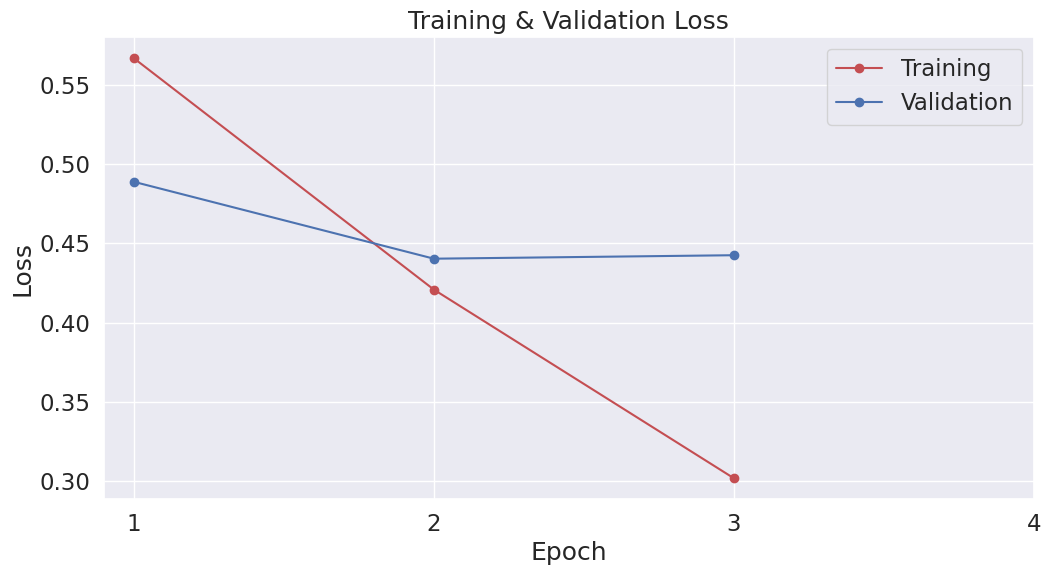

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(stats_df['Training Loss'], 'r-o', label="Training")
plt.plot(stats_df['Validation Loss'], 'b-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

Model Testing

In [ ]:
test_loader = preprocess_text(test_dataset, tokenizer, batch_size)

In [ ]:
pred_test_labels, true_test_labels, epoch_val_loss = model_eval_epoch(model, test_loader)

print(len(true_test_labels))

54


In [ ]:
# Calculate batchwise accuracy and F1 scores
acc_batch = []
f1_batch = []
for p_batch, t_batch in zip(pred_test_labels, true_test_labels):
  # Get labels of batch
  pred_labels =  np.argmax(p_batch, axis=1).flatten()

  # Calculate accuracy for the batch
  acc = smetrics.accuracy_score(t_batch, pred_labels)
  # Append accuracy score to list
  acc_batch.append(acc)

  # Calculate accuracy for the batch
  f1 = smetrics.f1_score(t_batch, pred_labels)
  # Append accuracy score to list
  f1_batch.append(f1)

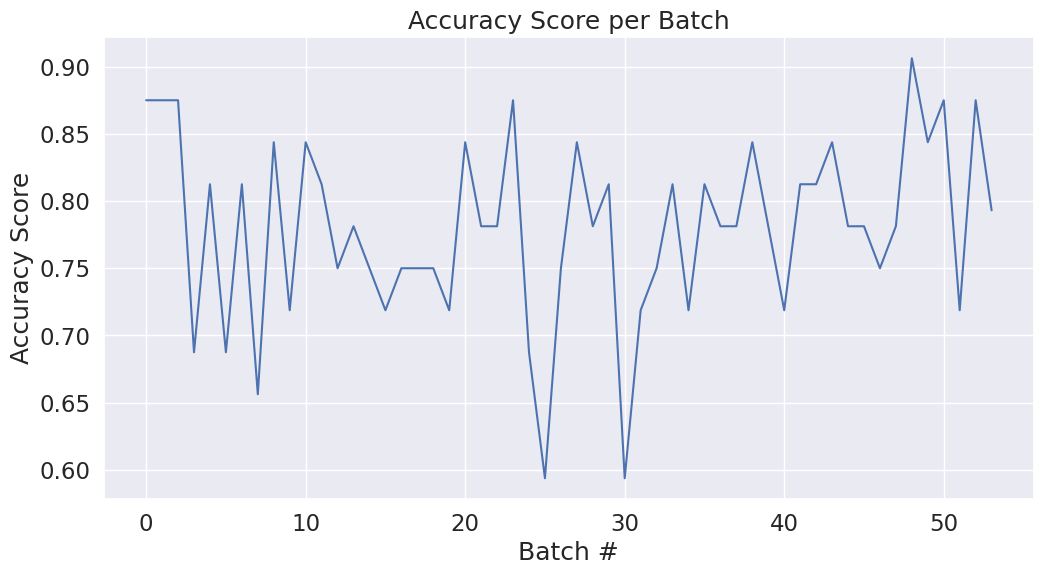

In [ ]:
# Plot accuracy vs batch
ax = sns.lineplot(x=list(range(len(acc_batch))), y=acc_batch, errorbar=None)

plt.title('Accuracy Score per Batch')
plt.ylabel('Accuracy Score')
plt.xlabel('Batch #')

plt.show()

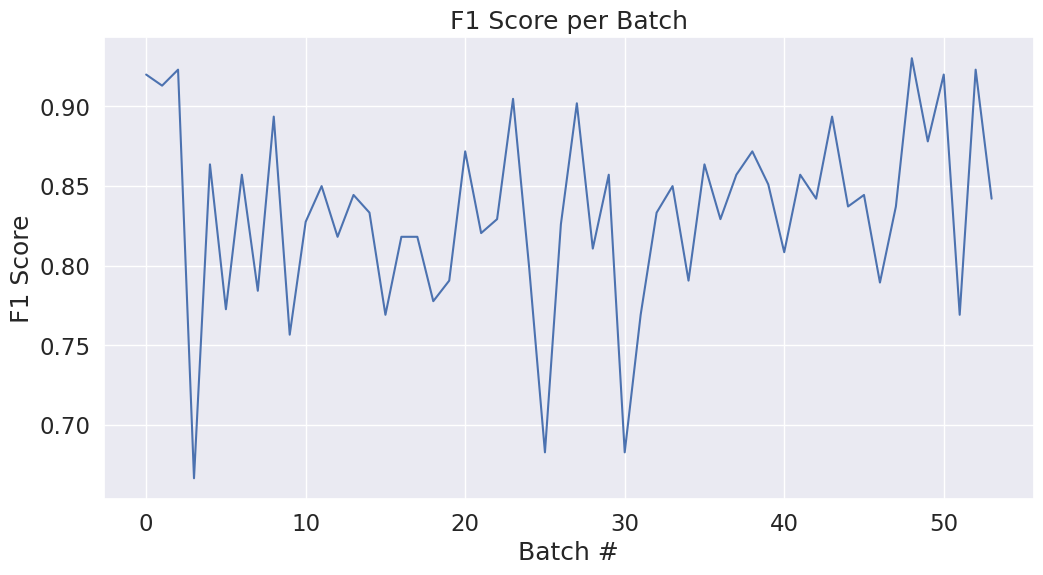

In [ ]:
# Plot accuracy vs batch
ax = sns.lineplot(x=list(range(len(f1_batch))), y=f1_batch, errorbar=None)

plt.title('F1 Score per Batch')
plt.ylabel('F1 Score')
plt.xlabel('Batch #')

plt.show()

In [ ]:
# Concatenate prediction across all batches
flat_pred_labels = np.concatenate(pred_test_labels, axis=0)

# Get labels
flat_pred_labels = np.argmax(flat_pred_labels, axis=1).flatten()

# Concatenate true labels across all batches
flat_true_labels = np.concatenate(true_test_labels, axis=0)

In [ ]:
# Get accuracy
acc = smetrics.accuracy_score(flat_true_labels, flat_pred_labels)

print('Accuracy: %.3f' % acc)

Accuracy: 0.780


In [ ]:
# Get F1 score
acc = smetrics.f1_score(flat_true_labels, flat_pred_labels)

print('F1 score: %.3f' % acc)

F1 score: 0.836


Save model

In [ ]:
# Directory to save model files
output_dir = './model/'

# Create directory if it doesn't exist
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

print("Saving model...")

# Save model config and tokenizer
model_save = model.module if hasattr(model, 'module') else model
model_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model...


('./model/tokenizer_config.json',
 './model/special_tokens_map.json',
 './model/vocab.txt',
 './model/added_tokens.json')

Load model

In [ ]:
'''
# Load a trained model and vocabulary that you have fine-tuned
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)
'''